##                               Smart Submeters for Smart Homes - Part 2

                            
                                     

### Explore and Visualize Energy Consumption
                      
 A regional home developer wants us to develop analytics for a new set of electrical 
 sub-metering devices used for power management in Smart Homes.

 After having taken an initial look at the sub-metered household data and a meeting
 with the management, the goal is now to develope potential business applications for
 smart-submeter users. Combining electricity consumption, documented by the submeters
 with further external data sources can provide useful customer benefit.

### Loading Libraries

In [ ]:
#####LOADING LIBRARIES#####

library(RMySQL)
library(DBI)
library(dplyr)
library(lubridate)
library(ggplot2)
library(lubridate)
library(anytime)
library(tidyverse)
library(arules)
library(base)
library(scales)
library(tidyr)
library(grid)
library(gridExtra)
library(forecast)
library(plotly)
library(readxl)
library(imputeTS)

### Data Connection & Retrieving Data

In [61]:
##Create a database connection

con = dbConnect(
  MySQL(),
  user = 'deepAnalytics',
  password = 'Sqltask1234!',
  dbname = 'dataanalytics2018',
  host = 'data-analytics-2018.cbrosir2cswx.us-east-1.rds.amazonaws.com')

#tables of data base listed 

dbListTables(con)
dbListFields(con,"yr_2006")


#request relevant data base tables


yr_2006 <-
  dbGetQuery(con,
             "SELECT Date, Time, Sub_metering_1, Sub_metering_2,
     Sub_metering_3, Global_active_power,Voltage,Global_intensity FROM yr_2006")

yr_2007 <-
  dbGetQuery(con,
             "SELECT Date, Time, Sub_metering_1, Sub_metering_2,
   Sub_metering_3, Global_active_power,Voltage,Global_intensity FROM yr_2007")

yr_2008 <- 
  dbGetQuery(con,
             "SELECT Date, Time, Sub_metering_1, Sub_metering_2,
     Sub_metering_3, Global_active_power,Voltage,Global_intensity FROM yr_2008")

yr_2009 <-
  dbGetQuery(con,
             "SELECT Date, Time, Sub_metering_1, Sub_metering_2,
     Sub_metering_3, Global_active_power,Voltage,Global_intensity FROM yr_2009")

yr_2010 <-
  dbGetQuery(con,
             "SELECT Date, Time, Sub_metering_1, Sub_metering_2,
     Sub_metering_3, Global_active_power,Voltage,Global_intensity FROM yr_2010")



[1] "iris"    "yr_2006" "yr_2007" "yr_2008" "yr_2009" "yr_2010"

[1] "id"                    "Date"                  "Time"                 
 [4] "Global_active_power"   "Global_reactive_power" "Global_intensity"     
 [7] "Voltage"               "Sub_metering_1"        "Sub_metering_2"       
[10] "Sub_metering_3"

In [62]:
#weather data for Paris
WeatherParis <- read.csv("WeatherParis.csv",sep=';')

### Data Preparation

In [63]:
#yr_2006 and yr_2010 excluded, no data for complete year

SmartSub <- bind_rows(yr_2007,yr_2008,yr_2009,yr_2010)

In [64]:
#Initial Exploration of Data Set

head(SmartSub)
str(SmartSub)
summary(SmartSub)

Date,Time,Sub_metering_1,Sub_metering_2,Sub_metering_3,Global_active_power,Voltage,Global_intensity
2007-01-01,00:00:00,0,0,0,2.580,241.97,10.6
2007-01-01,00:01:00,0,0,0,2.552,241.75,10.4
2007-01-01,00:02:00,0,0,0,2.550,241.64,10.4
2007-01-01,00:03:00,0,0,0,2.550,241.71,10.4
2007-01-01,00:04:00,0,0,0,2.554,241.98,10.4
2007-01-01,00:05:00,0,0,0,2.550,241.83,10.4


'data.frame':	2027288 obs. of  8 variables:
 $ Date               : chr  "2007-01-01" "2007-01-01" "2007-01-01" "2007-01-01" ...
 $ Time               : chr  "00:00:00" "00:01:00" "00:02:00" "00:03:00" ...
 $ Sub_metering_1     : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Sub_metering_2     : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Sub_metering_3     : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Global_active_power: num  2.58 2.55 2.55 2.55 2.55 ...
 $ Voltage            : num  242 242 242 242 242 ...
 $ Global_intensity   : num  10.6 10.4 10.4 10.4 10.4 10.4 10.4 10.2 10.2 10.2 ...


     Date               Time           Sub_metering_1   Sub_metering_2  
 Length:2027288     Length:2027288     Min.   : 0.000   Min.   : 0.000  
 Class :character   Class :character   1st Qu.: 0.000   1st Qu.: 0.000  
 Mode  :character   Mode  :character   Median : 0.000   Median : 0.000  
                                       Mean   : 1.121   Mean   : 1.289  
                                       3rd Qu.: 0.000   3rd Qu.: 1.000  
                                       Max.   :88.000   Max.   :80.000  
 Sub_metering_3   Global_active_power    Voltage      Global_intensity
 Min.   : 0.000   Min.   : 0.076      Min.   :223.2   Min.   : 0.200  
 1st Qu.: 0.000   1st Qu.: 0.308      1st Qu.:239.0   1st Qu.: 1.400  
 Median : 1.000   Median : 0.594      Median :241.0   Median : 2.600  
 Mean   : 6.448   Mean   : 1.083      Mean   :240.8   Mean   : 4.591  
 3rd Qu.:17.000   3rd Qu.: 1.520      3rd Qu.:242.9   3rd Qu.: 6.400  
 Max.   :31.000   Max.   :11.122      Max.   :254.2   Max.   :4

In [65]:
#set local time on english version

Sys.setlocale("LC_TIME", "C")

[1] "C"

In [66]:
#combine Date and Time to DateTime

SmartSub <-cbind(SmartSub,paste(SmartSub$Date,SmartSub$Time), stringsAsFactors=FALSE)

head(SmartSub)
#rename new feature

colnames(SmartSub)[9] <-"DateTime"

Date,Time,Sub_metering_1,Sub_metering_2,Sub_metering_3,Global_active_power,Voltage,Global_intensity,"paste(SmartSub$Date, SmartSub$Time)"
2007-01-01,00:00:00,0,0,0,2.580,241.97,10.6,2007-01-01 00:00:00
2007-01-01,00:01:00,0,0,0,2.552,241.75,10.4,2007-01-01 00:01:00
2007-01-01,00:02:00,0,0,0,2.550,241.64,10.4,2007-01-01 00:02:00
2007-01-01,00:03:00,0,0,0,2.550,241.71,10.4,2007-01-01 00:03:00
2007-01-01,00:04:00,0,0,0,2.554,241.98,10.4,2007-01-01 00:04:00
2007-01-01,00:05:00,0,0,0,2.550,241.83,10.4,2007-01-01 00:05:00


In [67]:
#move column to first place in data frame

SmartSub <- SmartSub[,c(ncol(SmartSub), 1:(ncol(SmartSub)-1))]

In [68]:
#remove redundant "Date" and "Time" features

SmartSub <- SmartSub[,-c(2,3)]

In [ ]:
#Convert DateTime into time format

SmartSub$DateTime <- as.POSIXct(SmartSub$DateTime, "%Y/%m/%d %H:%M:%S")

#Add time zone

attr(SmartSub$DateTime, "tzone") <- "Europe/Paris"

In [70]:
#create features 'year','quarter','month','week','weekday,'day','hour','minute'

SmartSub$year <- year(SmartSub$DateTime)

SmartSub$quarter <- quarter(SmartSub$DateTime)

SmartSub$month <- month(SmartSub$DateTime)

SmartSub$week <- week(SmartSub$DateTime)         

SmartSub$weekday <- weekdays(SmartSub$DateTime)

SmartSub$day <- day(SmartSub$DateTime)

SmartSub$hour <- hour(SmartSub$DateTime)

SmartSub$minute <- minute (SmartSub$DateTime)

In [71]:
#rename submeters 

SmartSub <- rename(SmartSub, submeter_kitchen = Sub_metering_1)

SmartSub <- rename(SmartSub, submeter_laundry = Sub_metering_2)

SmartSub <- rename(SmartSub, submeter_heat_AC = Sub_metering_3)

In [72]:
#new feature: measuring total power consumption

#convert kilo-watt into watt-minutes

SmartSub <- mutate(SmartSub, total_power = Global_active_power*1000 /60)

In [73]:
#implement new feature 'unknown' energy consumption(not represented in SmartSubmeters) into data set

SmartSub <-
  mutate(SmartSub,
         unknown = total_power - submeter_kitchen - submeter_laundry - submeter_heat_AC)

### Data Visualisation

Warning message:
"Removed 6263 rows containing missing values (geom_path)."

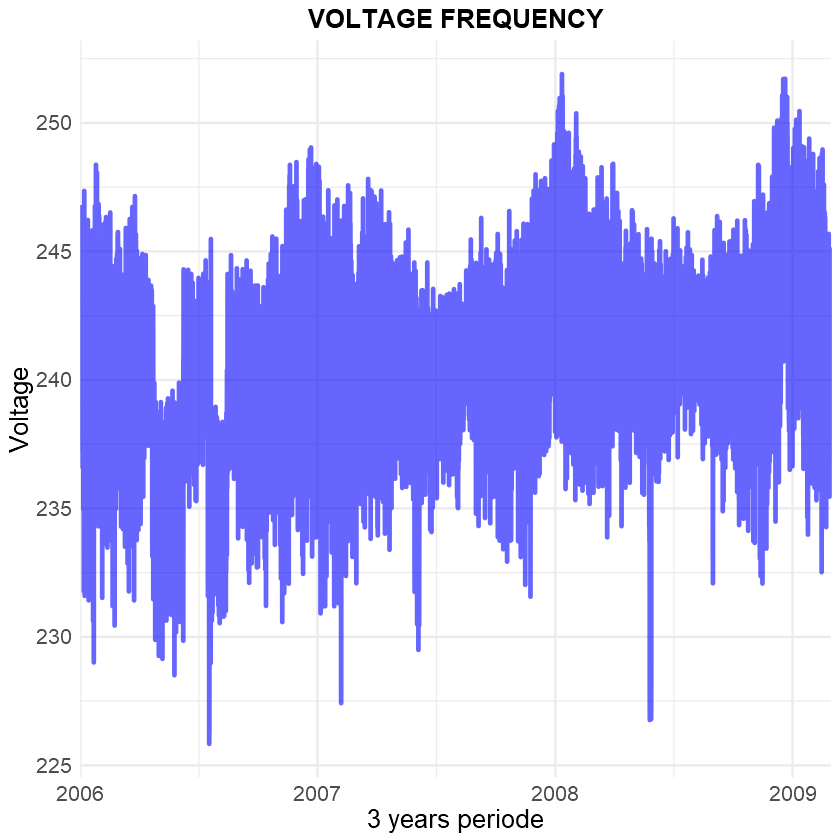

In [74]:
#Visualising 'Voltage' to check relevance of feature 

SmartSub1 <- SmartSub %>%
  group_by(DateTime = floor_date(DateTime, "1 hour")) %>%
  summarize(
    submeter_kitchen = sum(submeter_kitchen),
    submeter_laundry = sum(submeter_laundry),
    submeter_heat_AC = sum(submeter_heat_AC),
    unknown = sum(unknown),
    total_power = sum(total_power),
    Global_active_power =sum(Global_active_power),
    Voltage= mean(Voltage),
    Global_intensity=mean(Global_intensity)
  )

pl1_voltage <- ggplot(data = SmartSub1,aes(x = DateTime, y = Voltage)) +
  geom_line(color='blue',
            alpha = 0.6,
            size = 1) +
  labs(x = "3 years periode", 
       y = "Voltage") +
  ggtitle('VOLTAGE FREQUENCY') +
  theme_minimal()+
  theme(plot.title = element_text(size = 15, face = "bold", hjust = 0.5),
        text = element_text(size = 15))


pl2_voltage <-  pl1_voltage + scale_x_datetime(
  breaks = seq(
    as.POSIXct("2007-01-01 00:00:00"),
    as.POSIXct("2010-03-01 00:00:00"),
    "1 year"),
  labels = date_format("%Y"),
  expand = c(0, 0),
  limits = c(
    as.POSIXct("2007-01-01 00:00:00"),
    as.POSIXct("2010-03-01 00:00:00")
  )
)  

pl2_voltage

Warning message:
"Removed 540300 rows containing missing values (geom_path)."

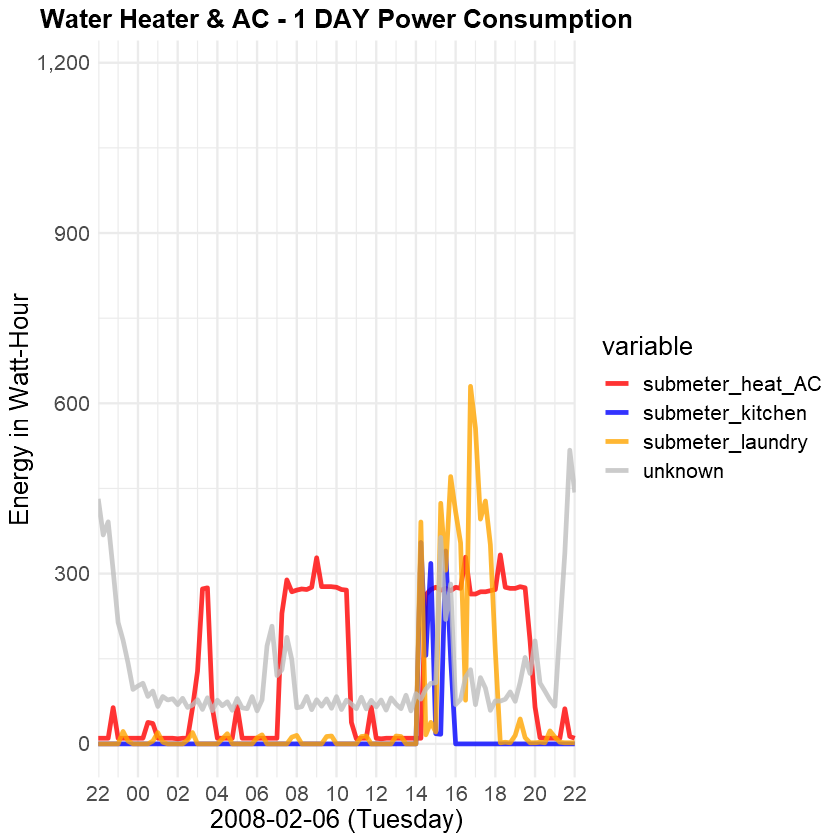

In [75]:
#Plotting Examples for energy consumption: 3 submeters combined 1 day


SmartSub1 <- SmartSub %>%
  group_by(DateTime = floor_date(DateTime, "15 minutes")) %>%
  summarize(
    submeter_kitchen = sum(submeter_kitchen),
    submeter_laundry = sum(submeter_laundry),
    submeter_heat_AC = sum(submeter_heat_AC),
    unknown = sum(unknown),
    total_power = sum(total_power),
    Global_active_power =sum(Global_active_power),
    Voltage= mean(Voltage),
    Global_intensity=mean(Global_intensity)
  )


SmartSub_mul <- SmartSub1 %>% 
  select (DateTime, submeter_heat_AC, submeter_kitchen, submeter_laundry, unknown) %>%
  gather(key = "variable", value = "value", -DateTime)


myplot <- ggplot(SmartSub_mul, aes(x = DateTime, y = value)) + 
  geom_line(aes(color = variable), alpha = 0.8,
            size = 1) +
  scale_color_manual(values = c( "red","blue", "orange","grey")) +
  labs(x = "2008-02-06 (Tuesday)", 
       y = "Energy in Watt-Hour") +
  ggtitle('Water Heater & AC - 1 DAY Power Consumption') +
  theme_minimal()+
  theme(plot.title = element_text(size = 15, face = "bold", hjust = 0.5),
        text = element_text(size = 15))+
  
  scale_x_datetime(
    breaks = seq(
      as.POSIXct("2008-05-06 00:00:00"),
      as.POSIXct("2008-05-07 00:00:00"),
      "2 hours"),
    labels = date_format("%H"),
    expand = c(0, 0),
    limits = c(
      as.POSIXct("2008-05-06 00:00:00"),
      as.POSIXct("2008-05-07 00:00:00")
    )
  )  +
  scale_y_continuous(labels = comma)

myplot

Warning message:
"Removed 134528 rows containing missing values (geom_path)."

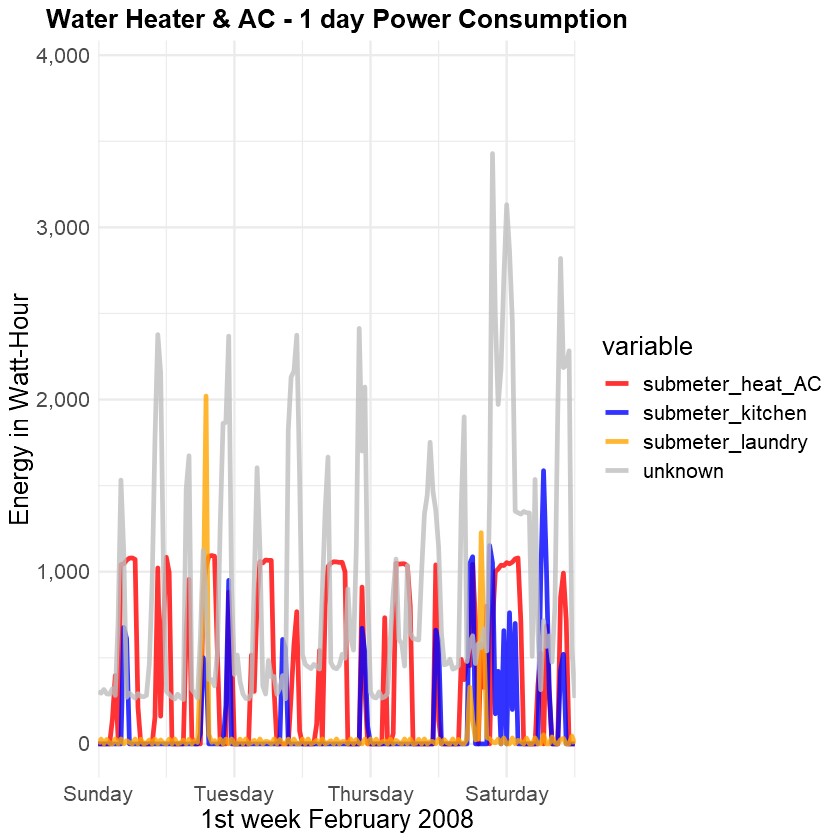

In [76]:
#plotting 3 submeters combined  1 week


SmartSub1 <- SmartSub %>%
  group_by(DateTime = floor_date(DateTime, "1 hour")) %>%
  summarize(
    submeter_kitchen = sum(submeter_kitchen),
    submeter_laundry = sum(submeter_laundry),
    submeter_heat_AC = sum(submeter_heat_AC),
    unknown = sum(unknown),
    total_power = sum(total_power),
    Global_active_power =sum(Global_active_power),
    Voltage= mean(Voltage),
    Global_intensity=mean(Global_intensity)
  )


SmartSub_mul <- SmartSub1 %>% 
  select (DateTime, submeter_heat_AC, submeter_kitchen, submeter_laundry, unknown) %>%
  gather(key = "variable", value = "value", -DateTime)


myplot <- ggplot(SmartSub_mul, aes(x = DateTime, y = value)) + 
  geom_line(aes(color = variable), alpha = 0.8,
            size = 1) +
  scale_color_manual(values = c( "red","blue", "orange","grey")) +
  labs(x = "1st week February 2008", 
       y = "Energy in Watt-Hour") +
  ggtitle('Water Heater & AC - 1 day Power Consumption') +
  theme_minimal()+
  theme(plot.title = element_text(size = 15, face = "bold", hjust = 0.5),
        text = element_text(size = 15))+
   scale_x_datetime(
    breaks = seq(
      as.POSIXct("2008-01-07 00:00:00"),
      as.POSIXct("2008-01-14 00:00:00"),
      "2 days"),
    labels = date_format("%A"),
    expand = c(0, 0),
    limits = c(
      as.POSIXct("2008-01-07 00:00:00"),
      as.POSIXct("2008-01-14 00:00:00")
    )
  )  +
  scale_y_continuous(labels = comma)

myplot

In [77]:
head(WeatherParis)
str(WeatherParis)

DateTime,temperature
01.12.2006 01:00,6.7
01.12.2006 07:00,5.1
01.12.2006 13:00,9.0
01.12.2006 19:00,9.6
02.12.2006 01:00,8.8
02.12.2006 07:00,9.5


'data.frame':	11427 obs. of  2 variables:
 $ DateTime   : Factor w/ 11427 levels "01.01.2007 01:00",..: 346 347 348 349 722 723 724 1097 1098 1099 ...
 $ temperature: num  6.7 5.1 9 9.6 8.8 9.5 10.5 7.7 9.8 10.5 ...


In [ ]:
# preprocessing weather data for Paris

#Convert DateTime into time format

WeatherParis$DateTime <- as.POSIXct(SmartSub$DateTime, "%Y/%m/%d %H:%M:%S")

#Add time zone

attr(WeatherParis$DateTime, "tzone") <- "Europe/Paris"

In [78]:
#merging (left outer join) weather data with Data Frame for Submeters

SmartSub_T <- merge(SmartSub, WeatherParis, by = "DateTime",all.x = TRUE)

In [ ]:
#Replacing missing values by interpolating temperature

SmartSub_T$temperature <- na.interpolation(SmartSub_T$temperature)

In [80]:
#function to include 2-tariff energy prices

SmartSub_T$energy_price <- 1

myfunction <- function (x) {
  
  if (x>=0 & x <=7)
  { return(0.0001244)
  }    
  else{
    return(0.0001593)
  }
}

SmartSub_T$energy_price <- sapply(SmartSub_T$hour,myfunction)

In [81]:
SmartSub1 <- SmartSub_T %>%
  group_by(DateTime = floor_date(DateTime, "15 minutes")) %>%
  summarize(
    submeter_kitchen = sum(submeter_kitchen),
    submeter_laundry = sum(submeter_laundry),
    submeter_heat_AC = sum(submeter_heat_AC),
    unknown = sum(unknown),
    total_power = sum(total_power),
    Global_active_power =sum(Global_active_power),
    Voltage= mean(Voltage),
    Global_intensity=sum(Global_intensity),
    energy_price = mean(energy_price)
    
  )

In [82]:
#creating column for total energy costs

SmartSub2 <- as.data.frame(SmartSub1)

SmartSub2 <- mutate(SmartSub2, energy_costs=energy_price * total_power)

#saving it in separate file
write.csv(SmartSub2, file="SmartSub21.csv")

In [83]:
#preprocess Data of year 2010 for Energy Mix analysis

SmartSub_10 <- yr_2010

SmartSub_10 <- cbind(SmartSub_10,paste(SmartSub_10$Date, SmartSub_10$Time),
        stringsAsFactors = FALSE)

In [84]:
#rename new feature

colnames(SmartSub_10)[9] <-"DateTime"

In [85]:
#move column to first place in data frame

SmartSub_10 <- SmartSub_10[,c(ncol(SmartSub_10), 1:(ncol(SmartSub_10)-1))]

#remove redundant "Date" and "Time" features

SmartSub_10 <- SmartSub_10[,-c(2,3)]

#Convert DateTime into time format

SmartSub_10$DateTime <- as.POSIXct(SmartSub_10$DateTime, "%Y/%m/%d %H:%M:%S")

#Add time zone

attr(SmartSub_10$DateTime, "tzone") <- "Europe/Paris"

Warning message in strptime(xx, f, tz = tz):
"unknown timezone '%Y/%m/%d %H:%M:%S'"Warning message in as.POSIXct.POSIXlt(x):
"unknown timezone '%Y/%m/%d %H:%M:%S'"Warning message in strptime(x, f, tz = tz):
"unknown timezone '%Y/%m/%d %H:%M:%S'"Warning message in as.POSIXct.POSIXlt(as.POSIXlt(x, tz, ...), tz, ...):
"unknown timezone '%Y/%m/%d %H:%M:%S'"

In [86]:
#create features 'year','quarter','month','week','weekday,'day','hour','minute'

SmartSub_10$year <- year(SmartSub_10$DateTime)

SmartSub_10$quarter <- quarter(SmartSub_10$DateTime)

SmartSub_10$month <- month(SmartSub_10$DateTime)

SmartSub_10$week <- week(SmartSub_10$DateTime)         

SmartSub_10$weekday <- weekdays(SmartSub_10$DateTime)

SmartSub_10$day <- day(SmartSub_10$DateTime)

SmartSub_10$hour <- hour(SmartSub_10$DateTime)

SmartSub_10$minute <- minute (SmartSub_10$DateTime)

In [87]:
#rename submeters 

SmartSub_10 <- rename(SmartSub_10, submeter_kitchen = Sub_metering_1)
SmartSub_10 <- rename(SmartSub_10, submeter_laundry = Sub_metering_2)
SmartSub_10 <- rename(SmartSub_10, submeter_heat_AC = Sub_metering_3)

In [88]:
#convert kilo-watt into watt-minutes

SmartSub_10 <- mutate(SmartSub_10, total_power = Global_active_power*1000 /60)

SmartSub_10 <-
  mutate(SmartSub_10,
         unknown = total_power - submeter_kitchen - submeter_laundry - submeter_heat_AC)

In [ ]:
#Energy Mix Data for France

EnergyMix <- read_csv("EnergyMix.csv")

In [ ]:
EnergyMix <- as.data.frame(EnergyMix)

#change data format from character to numerical

EnergyMix[2:11] <- lapply(EnergyMix[2:11], as.numeric)

In [ ]:
#transform DateTime into time format

EnergyMix$DateTime <- gsub("T"," ",EnergyMix$DateTime)

EnergyMix$DateTime <- as.POSIXct(strptime(EnergyMix$DateTime, "%Y-%m-%d %H:%M:%S"))

In [ ]:
#join Submeter Data with Energy Mix

SmartSub_10 <- merge(SmartSub_10, EnergyMix, by = "DateTime")

SmartSub_10[18:27]  <- lapply(SmartSub_10[18:27],na.interpolation)

In [ ]:
SmartSub_10 <- mutate(SmartSub_10,clean_index=`total consumption`/Co2)

### Time Series Analysis and Forecasting

In [94]:
#example for time series, random week in 2008

houseWeek <- filter(SmartSub_T, year == 2008 & week==4)

In [95]:
SmartSub1 <- houseWeek %>%
  group_by(DateTime = floor_date(DateTime, "1 hour")) %>%
  summarize(
    submeter_kitchen = sum(submeter_kitchen),
    submeter_laundry = sum(submeter_laundry),
    submeter_heat_AC = sum(submeter_heat_AC),
    unknown = sum(unknown),
    total_power = sum(total_power),
    Global_active_power =sum(Global_active_power),
    Voltage= mean(Voltage),
    Global_intensity=mean(Global_intensity),
    temperature=mean(temperature)
  )

In [96]:
#transform data set into time series

submeter_AC_weekly_TS <-
  ts(SmartSub1$submeter_kitchen,
     frequency = 24)

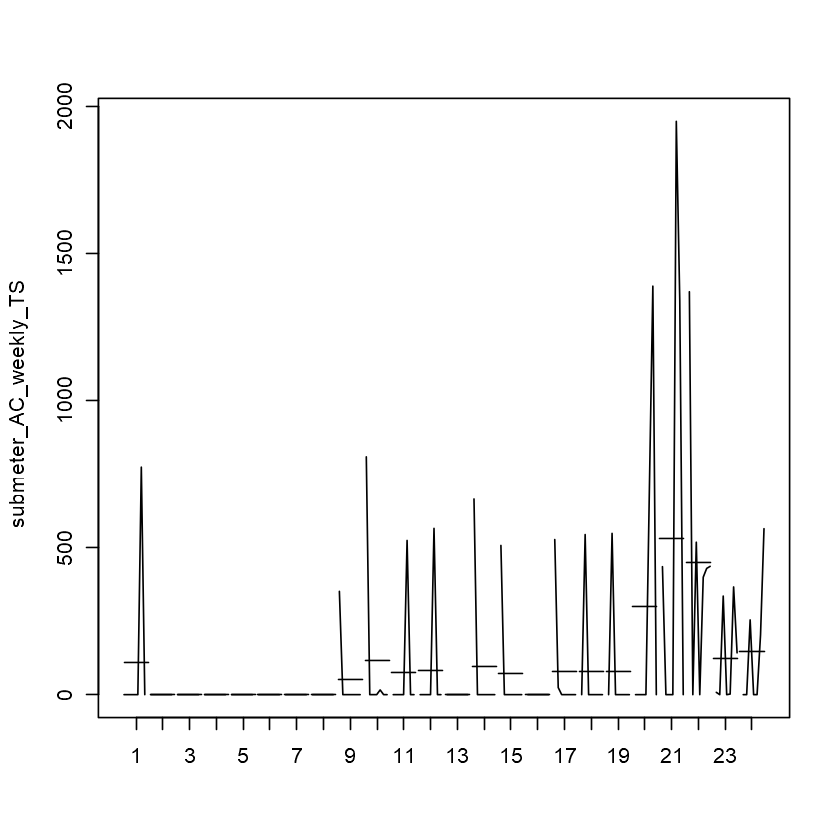

In [97]:
monthplot(submeter_AC_weekly_TS)

In [101]:
#initial exploration of time series

class(submeter_AC_weekly_TS)

start(submeter_AC_weekly_TS)

end(submeter_AC_weekly_TS)

frequency(submeter_AC_weekly_TS)

summary(submeter_AC_weekly_TS)

[1] "ts"

[1] 1 1

[1]  7 24

[1] 24

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00    0.00    0.00   99.32    0.00 1948.00 

In [105]:
#apply time series linear regression

fitSM3 <- tslm(submeter_AC_weekly_TS ~ trend + season) 

summary(fitSM3)


Call:
tslm(formula = submeter_AC_weekly_TS ~ trend + season)

Residuals:
    Min      1Q  Median      3Q     Max 
-534.02  -81.32   -3.46    1.15 1417.44 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)   
(Intercept)  113.93645  106.27591   1.072  0.28549   
trend         -0.04805    0.43163  -0.111  0.91151   
season2     -110.38052  143.53994  -0.769  0.44317   
season3     -110.33247  143.54189  -0.769  0.44337   
season4     -110.28441  143.54514  -0.768  0.44358   
season5     -110.23636  143.54968  -0.768  0.44379   
season6     -110.18831  143.55552  -0.768  0.44401   
season7     -110.14025  143.56266  -0.767  0.44423   
season8     -110.09220  143.57109  -0.767  0.44446   
season9      -59.90129  143.58082  -0.417  0.67716   
season10       7.71819  143.59185   0.054  0.95721   
season11     -35.09090  143.60418  -0.244  0.80730   
season12     -29.18570  143.61780  -0.203  0.83925   
season13    -109.85193  143.63272  -0.765  0.44564   
season14     -14.80

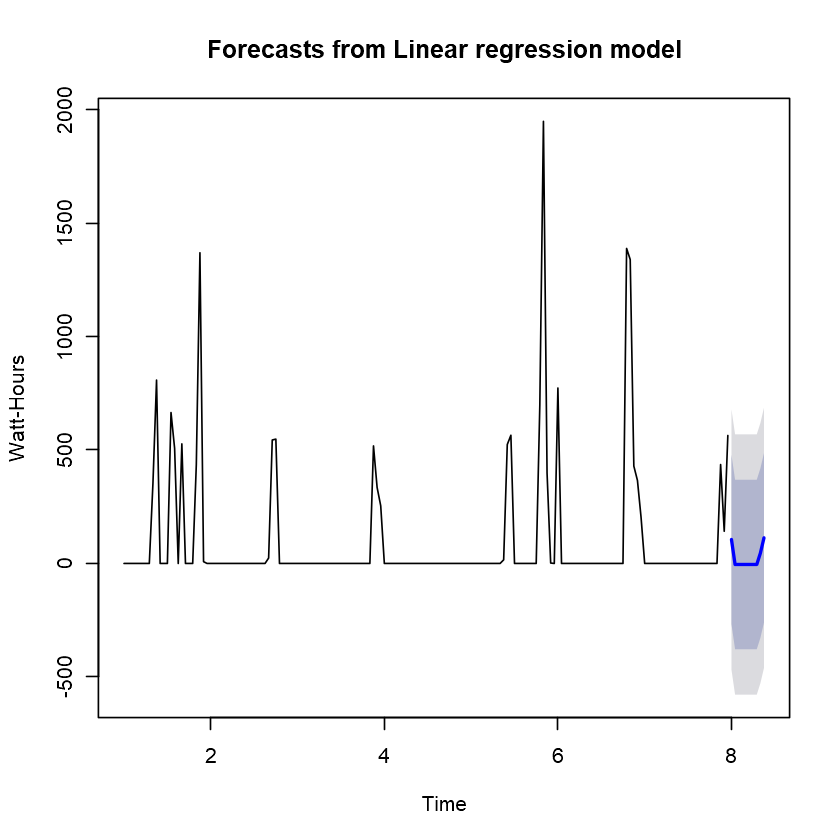

In [109]:
#making and plotting forecast

forecastfitSM3 <- forecast(fitSM3, h=10)

plot(forecastfitSM3,ylab= "Watt-Hours", xlab="Time")

         Length Class  Mode     
x        168    ts     numeric  
seasonal 168    ts     numeric  
trend    168    ts     numeric  
random   168    ts     numeric  
figure    24    -none- numeric  
type       1    -none- character

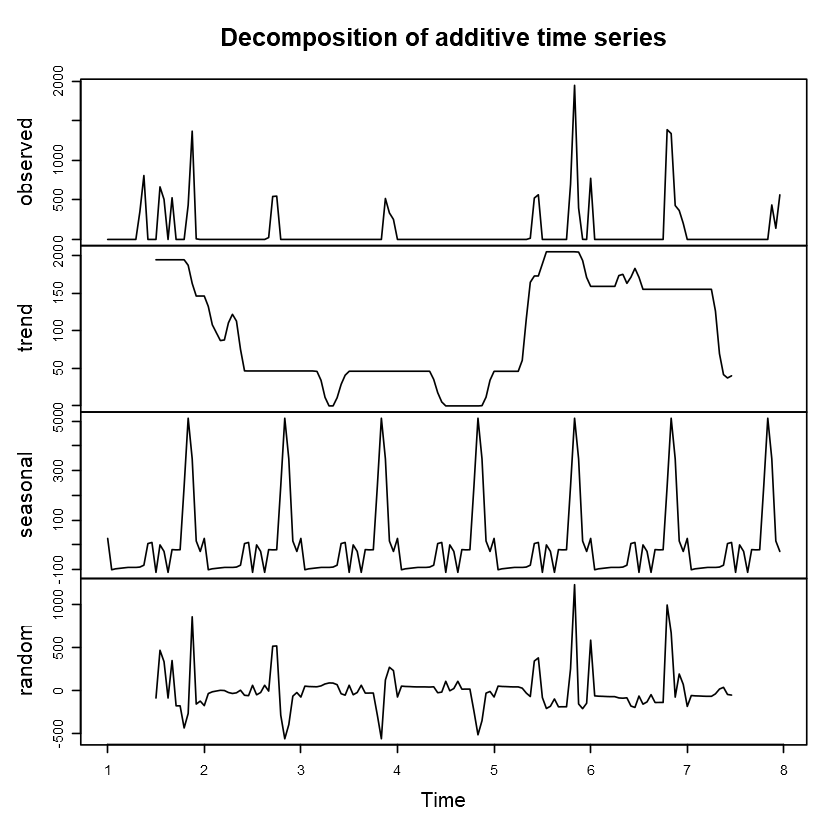

In [110]:
#decomposing time series into trend, seasonal, random parts

components070809SM3weekly <- decompose(submeter_AC_weekly_TS)

plot(components070809SM3weekly)

summary(components070809SM3weekly)